# 01_NBS_ Exploratory Data Analysis - EDA

## Purpose

The purpose of this notebook is to make some data exploration to undertand the data, and check the types of the data and the terminology we want to discover (e.g. dependencies, stationarity, differencing, specification, etc).

## Methodology
The approach used to made this EDA are: visualize time series data, patterns, additive and multiplicative time series, decomposition, stationarity and non-stationarity, testing stationarity, autocorrelation and partial autocorrelation.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- Build a complete EDA for forecasting;
- Write the results of this analysis;
- Define the next step thinking in statical modeling or machine learning modeling.

## Results
If you look for the first graph, we can visualize that all the values are positive, so we can show on this on both sizes of the Y axis to emphasize the growth. The monthly time series follows a certain pattern every year.

Another important observation is if we look for the additive decomposition residuals it has some pattern left over. The other hand, the multiplicative decomposition residual looks quite random which is good.

## Suggested next steps
To do.

# Setup

## Library import
We import all the required Python libraries

In [59]:
# Data manipulation
import pandas as pd
import numpy as np
from dateutil.parser import parser

# Statistical
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters import bk_filter, hp_filter
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Data Statistical/Visualization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

%matplotlib inline

## Local library import
We import all the required local libraries libraries

In [2]:
import os

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data load
We retrieve all the required data for the analysis.

In [3]:
data_path = "../data/AirPassengers.csv.xls"

df = pd.read_csv(data_path)
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [170]:
df['Month'] = pd.to_datetime(df['Month'])

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


# Data processing

## Data Visualization

In [190]:
def plot_date(df: pd.DataFrame):
    """This function plot the distribution of the number of passengers correlational to the monthly reported_

    Args:
        df (pd.DataFrame): dataframe
    """

    fig = plt.figure(figsize=(20, 5), dpi=200)
    ax = fig.add_subplot(1,1,1)  
    # df.set_index('Month').plot(figsize=(20, 5), color="purple")
    plt.plot(df["Month"], df["#Passengers"], color="purple")
    plt.title("Number of US Airline passengers from 1949 to 1960")
    # ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.show()


def plot_two_side(df: pd.DataFrame):
    """This function plot the two sides of the Air passenger to verify if has a pattern of the monthly

    Args:
        df (pd.DataFrame): dataframe
    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=100)
    plt.fill_between(x=df["Month"].values, y1=df["#Passengers"].values, y2=-df["#Passengers"].values,
                     alpha=0.5, linewidth=2, color="purple")
    plt.ylim(-800, 800)
    # plt.xlim(-800, 800)
    plt.title("Air passengers (Two side view)", fontsize=16)
    plt.hlines(y=0, xmin=np.min(df["Month"]), xmax=np.max(df["Month"]), linewidth=5)
    # ax.xaxis.set_major_locator(mdates.DayLocator(interval=30,))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.show()

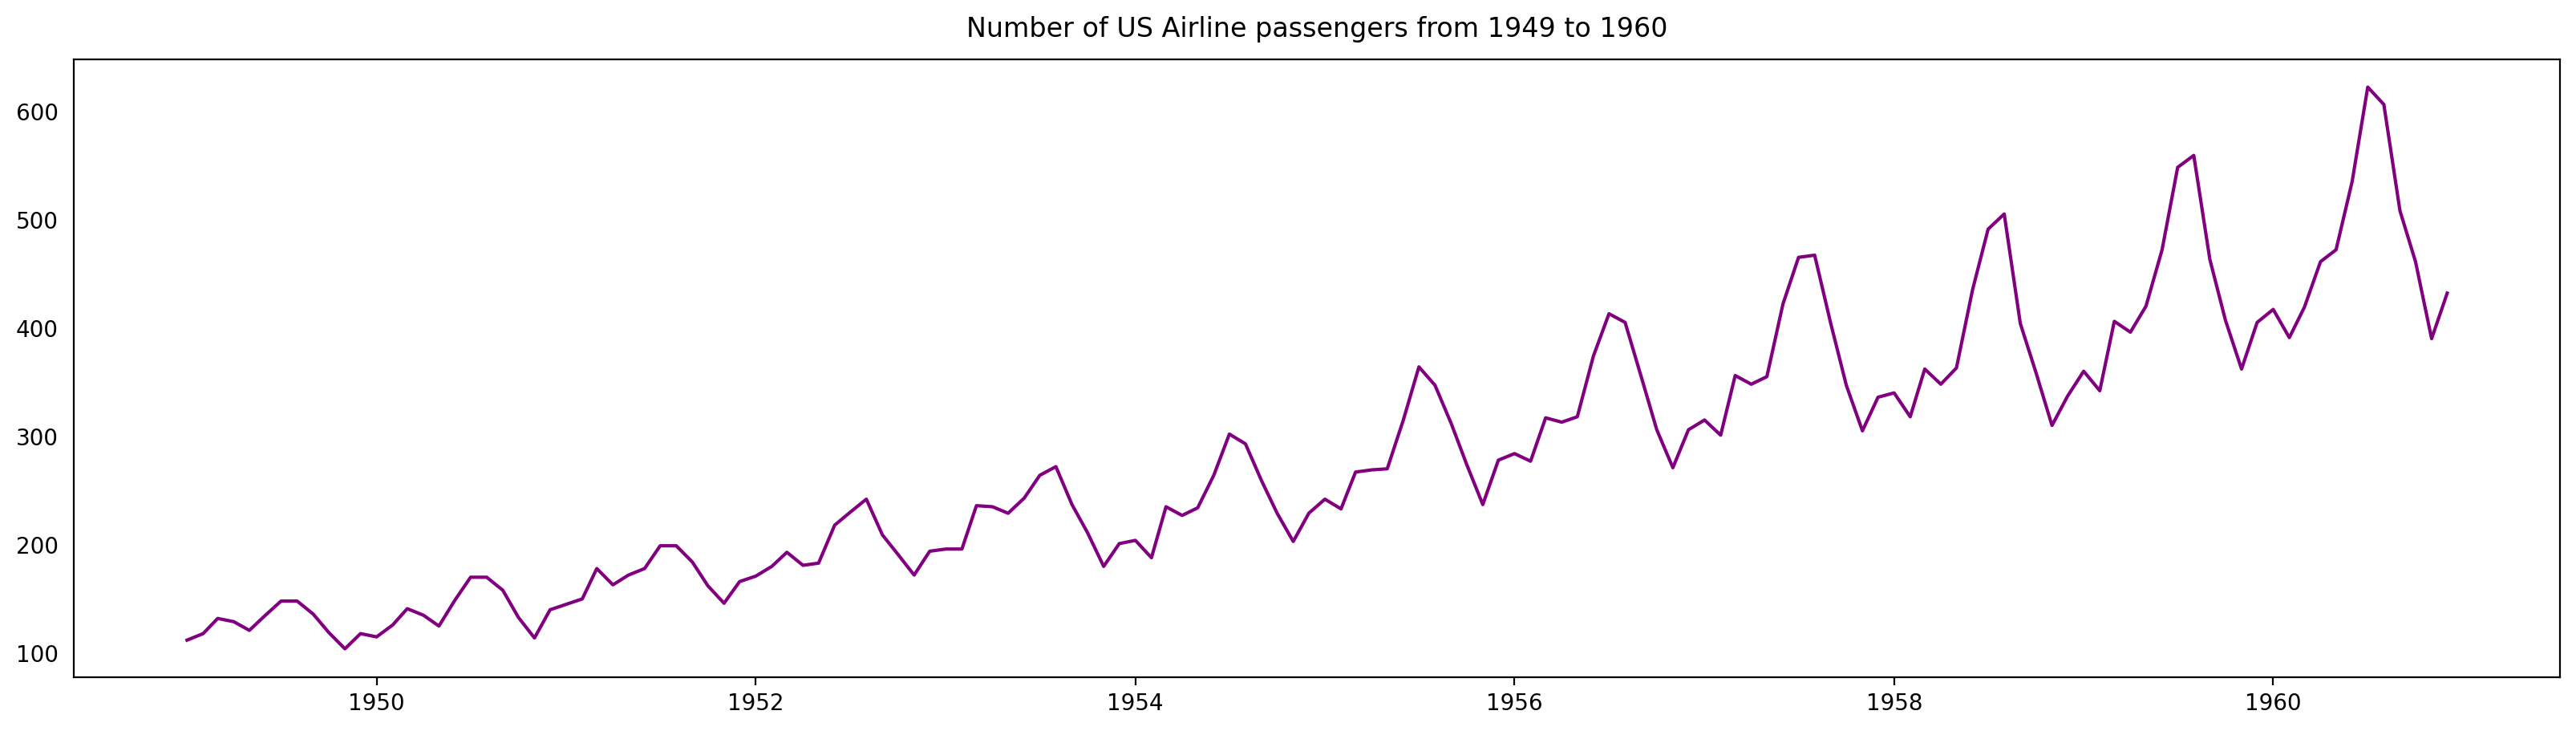

In [191]:
plot_date(df)

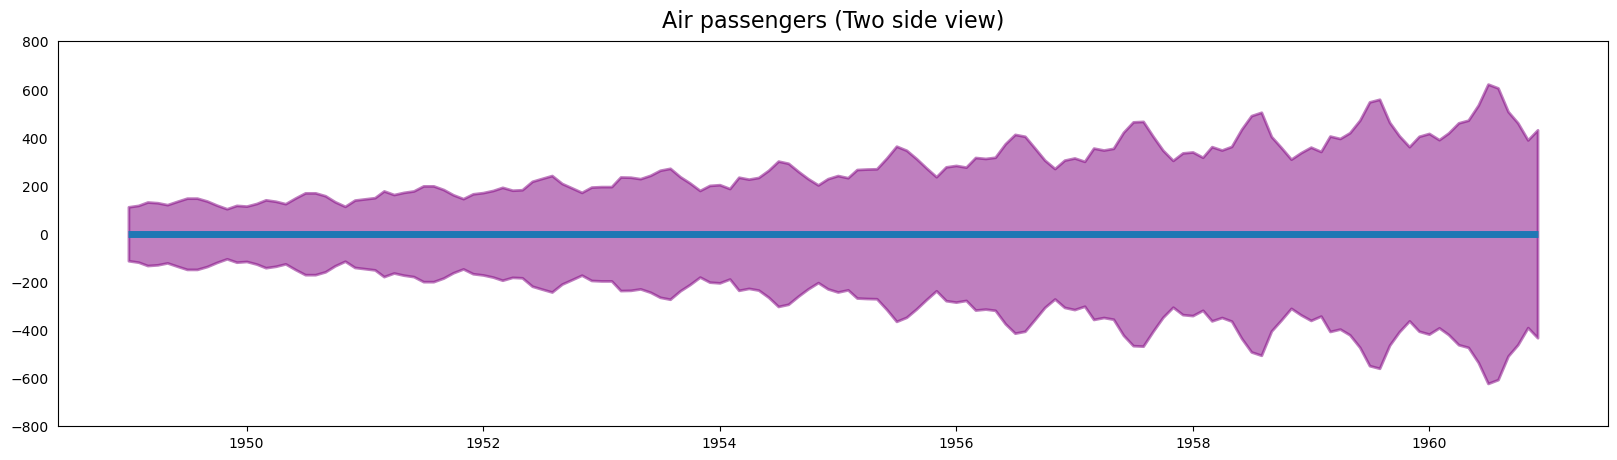

In [192]:
plot_two_side(df)

## Decomposition

In [7]:
def timeseries_decomposition(df: pd.DataFrame, period=30):
    """This function caculate the multiplicative and additive decomposition of the time series

    Args:
        df (pd.DataFrame): dataframe
        period (int, optional): period of the time series data. Defaults to 30.

    Returns:
        tuple: tuple contained the multiplicative and additive decomposition
    """
    mult_decomposition = seasonal_decompose(df["#Passengers"], model="multiplicative", period=period)
    add_decomposition = seasonal_decompose(df["#Passengers"], model="additive", period=period)
    return (mult_decomposition, add_decomposition)


def plot_decomposition(model_plot, title='', rect=[0, 0.05, 1, 0.95]):
    """This function plot the decomposition models

    Args:
        model_plot (statsmodels.tsa.seasonal.DecomposeResult): Seasonality plot model
        title (str, optional): Title of the plot. Defaults to ''.
        rect (list, optional): range of tight_layout. Defaults to [0, 0.05, 1, 0.95].
    """
    
    plt.rcParams.update({"figure.figsize": (20, 5)})
    model_plot.suptitle(title, fontsize=16)
    plt.tight_layout(rect=rect)
    plt.show()

In [8]:
mult_decomposition, add_decomposition = timeseries_decomposition(df)

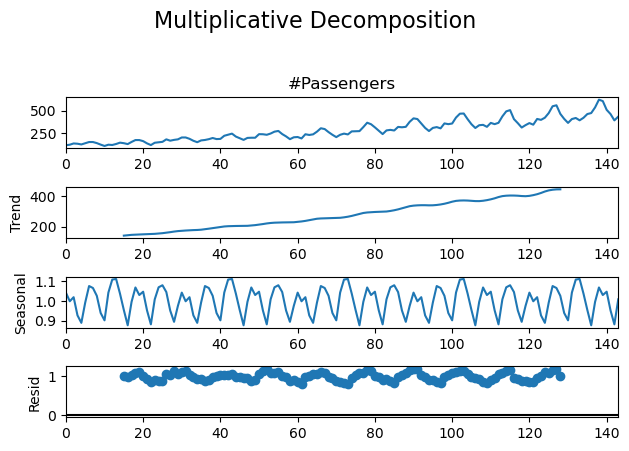

In [9]:
plot_decomposition(mult_decomposition.plot(), title="Multiplicative Decomposition")

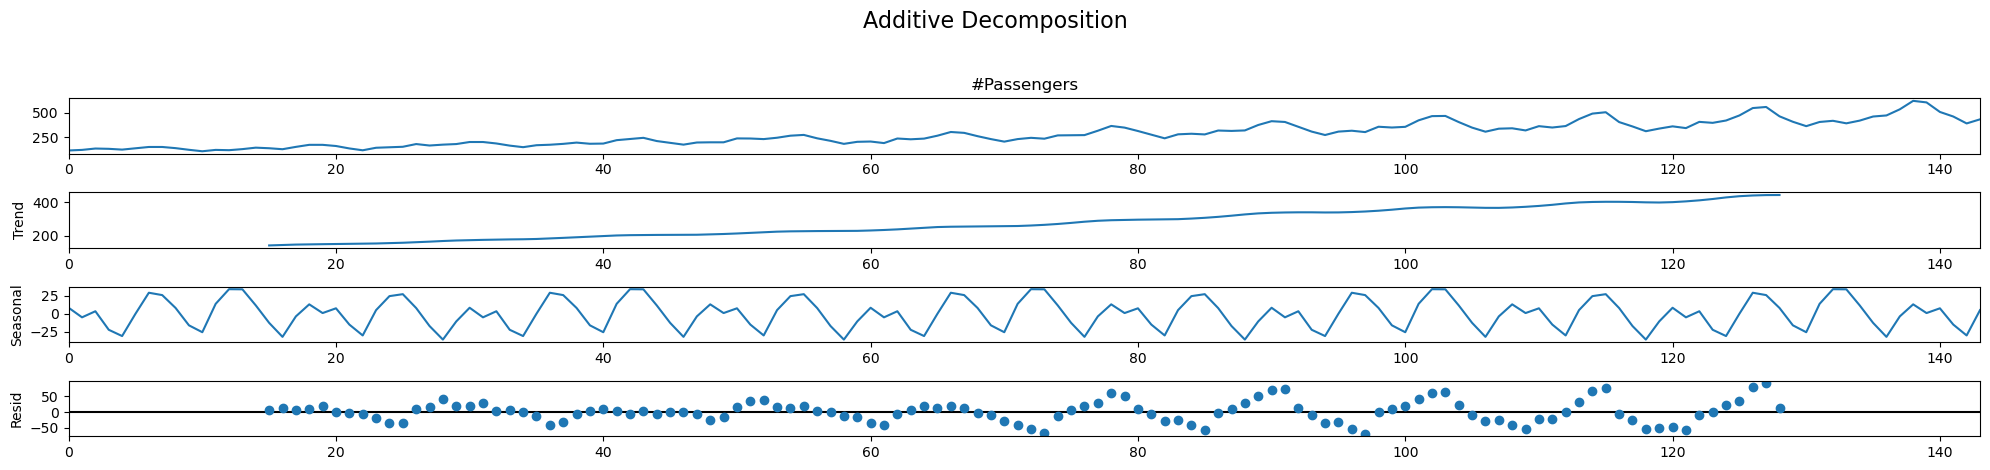

In [10]:
plot_decomposition(add_decomposition.plot(), title="Additive Decomposition")

## Detrend

In [11]:
def detrend_timeseries(df: pd.DataFrame, mode="linear_regression", decomposition=None):
    """This function use some methods to detrend the timeseries feature

    Args:
        df (pd.DataFrame): datafrane
        mode (str, optional): detrend method. Defaults to "linear_regression".
        decomposition (np.ndarray, optional): If the detrend method it is "decomposition" the variable will be not None. Defaults to None.

    Returns:
        _type_: dtrend ndarray
    """
    if (mode == "linear_regression"):
        detrend = signal.detrend(df["#Passengers"].values)
    elif (mode == "decomposition" and decomposition is not None):
        detrend = df["#Passengers"].values - decomposition.trend
    elif (mode == "differencing"):
        x = df["#Passengers"].values
        detrend = [x[i] - x[i - 1] for i in range(1, len(x))]
    elif (mode == "bkfilter"):
        detrend =  bk_filter.bkfilter(df["#Passengers"].values, low=6, high=24, K=12)
    return detrend


def plot_detrend(detrend: np.ndarray, title: str):
    """This function plot the trend result

    Args:
        detrend (ndarray): the dtrend result
        title (str): title of the plot
    """
    plt.figure(figsize=(20, 5), dpi=100)
    plt.plot(detrend, color="purple")
    plt.title(title)
    plt.show()


### Subtracking the line using Linear Regression

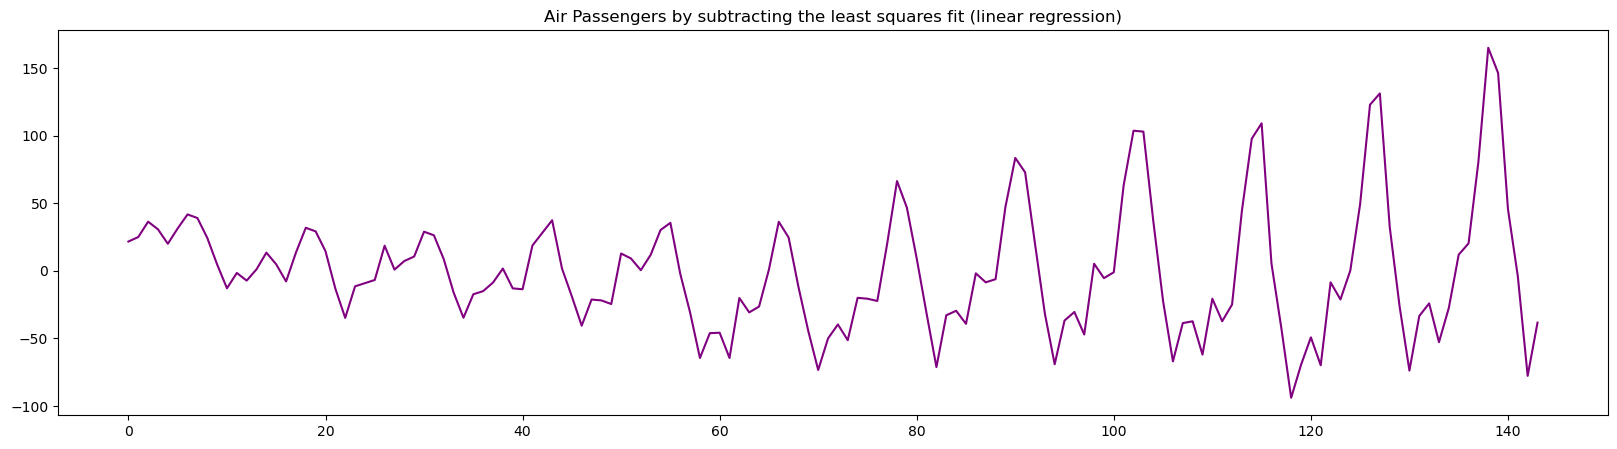

In [12]:
detrend = detrend_timeseries(df)
plot_detrend(detrend, title="Air Passengers by subtracting the least squares fit (linear regression)")

### Subtracting the trend compents using decomposition

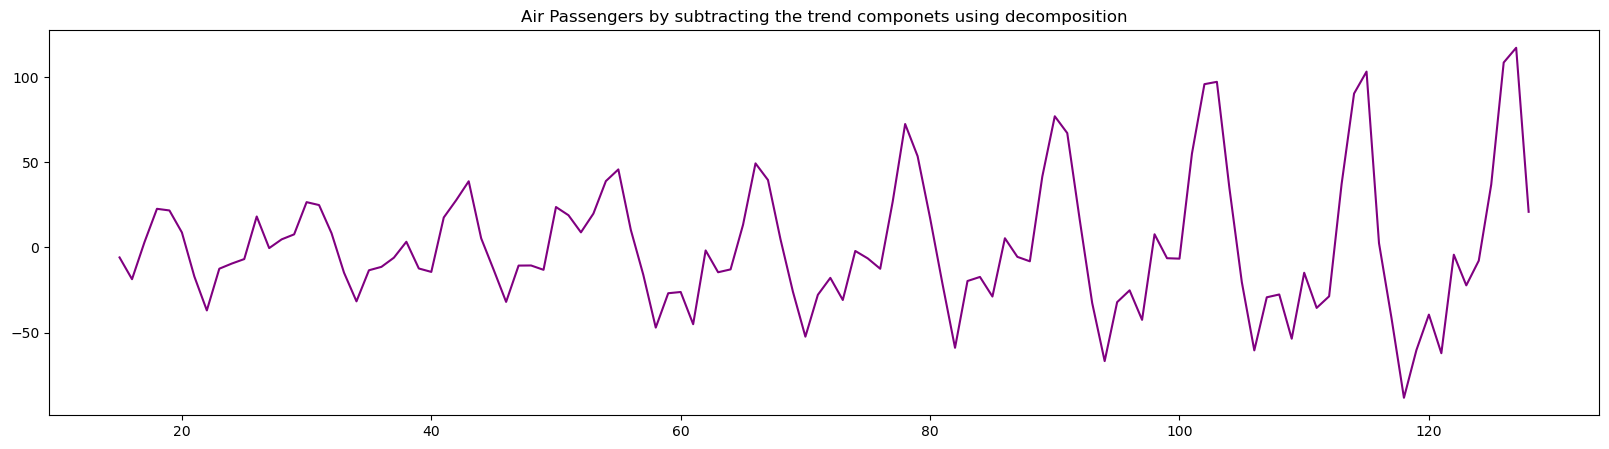

In [13]:
detrend = detrend_timeseries(df, mode="decomposition", decomposition=mult_decomposition)
plot_detrend(detrend, title="Air Passengers by subtracting the trend componets using decomposition")

### Subtracking the differencing of the time series

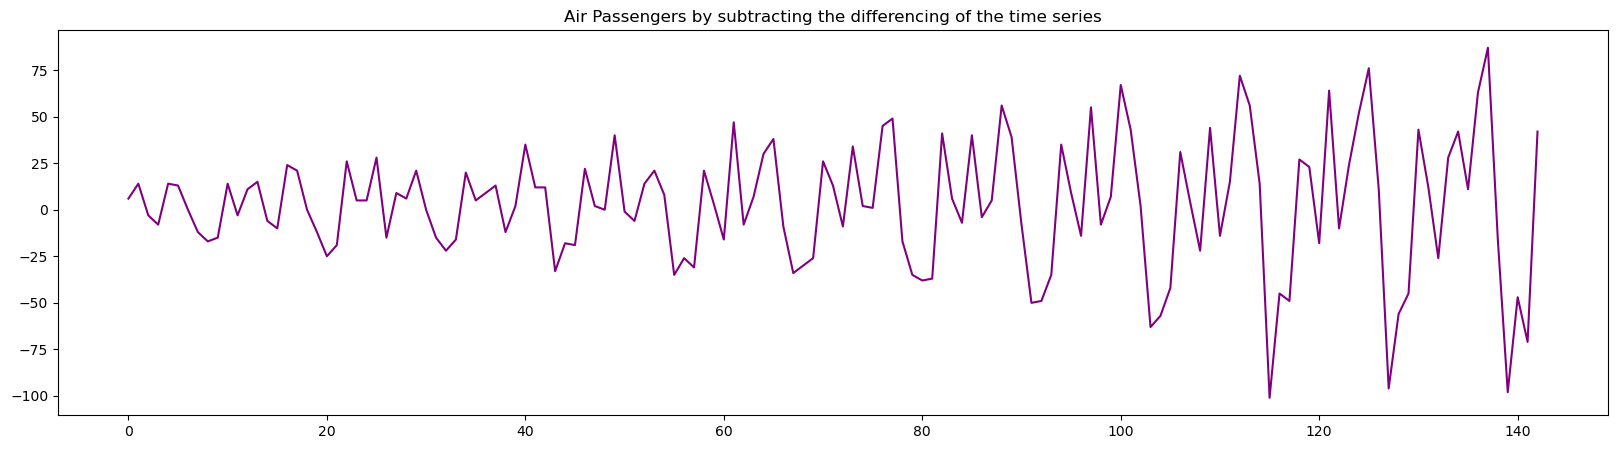

In [14]:
detrend = detrend_timeseries(df, mode="differencing")
plot_detrend(detrend, title="Air Passengers by subtracting the differencing of the time series")

### Apply statistical filter

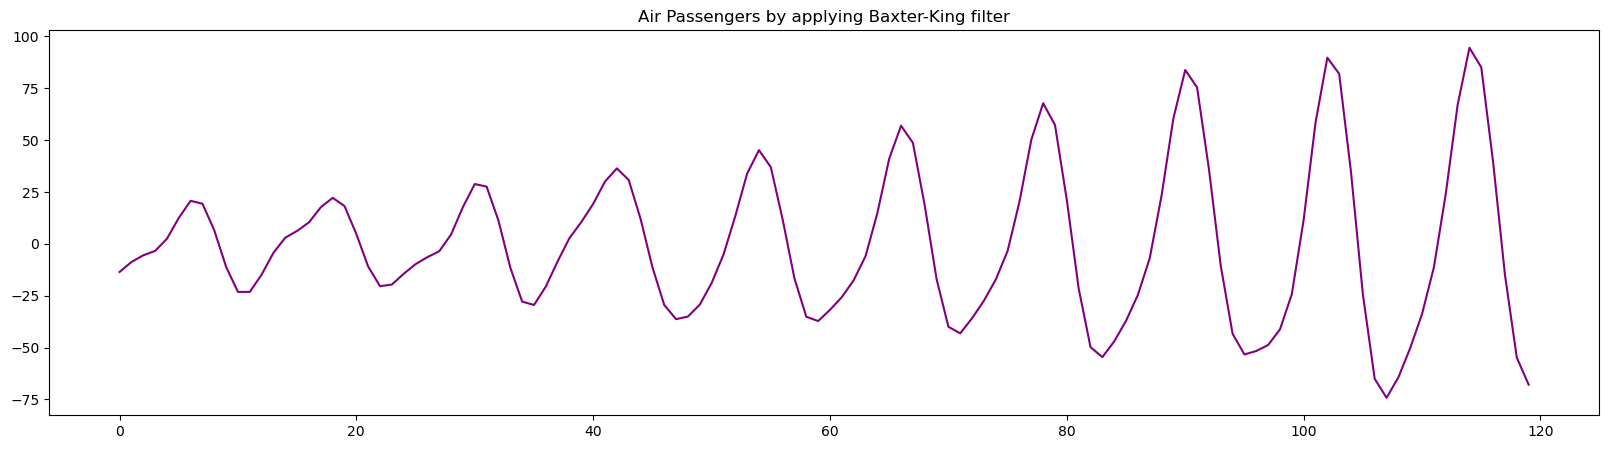

In [15]:
detrend = detrend_timeseries(df, mode="bkfilter")
plot_detrend(detrend, title="Air Passengers by applying Baxter-King filter")

## Check Auto Correlation and ADF test

## Plot AutoCorrelation

In [29]:
def plot_autocorrelation(df: pd.DataFrame, title='Air Passengers Auto Correlation'):
    """This function plot the deseasonality result

    Args:
        df (pd.DataFrame): Dataframe to be ploted.
        title (str, optional): Title of the plot. Defaults to ''.
    """
    plt.figure(figsize=(20, 8), dpi=10)
    plot_acf(df["#Passengers"], color="purple")
    plt.title(title)
    plt.show()

<Figure size 200x80 with 0 Axes>

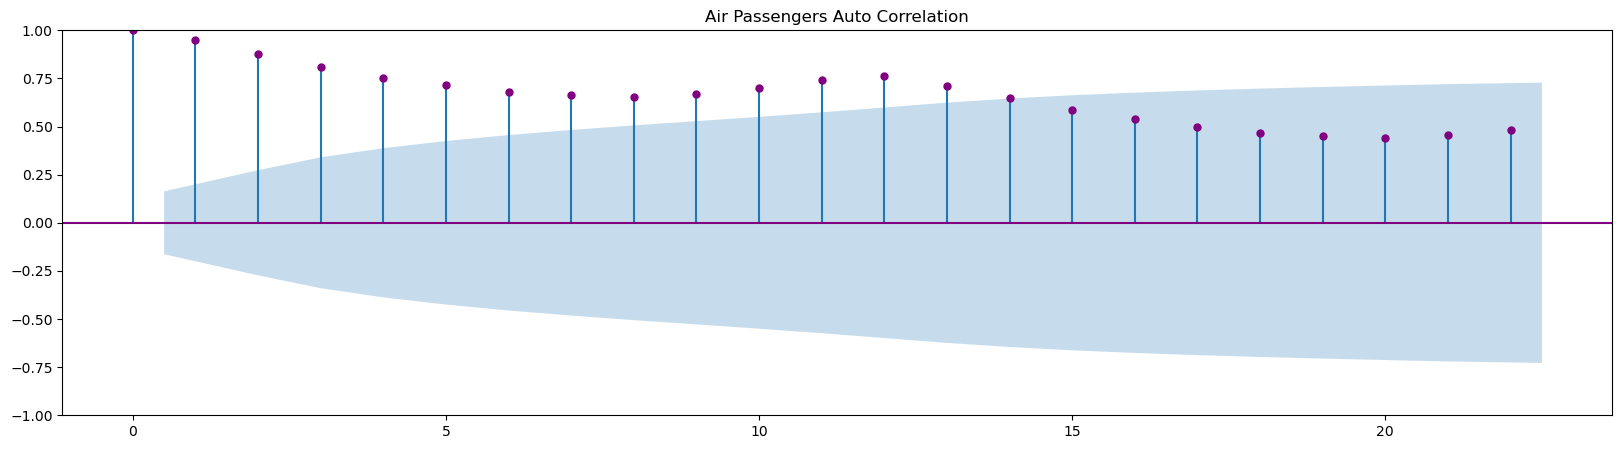

In [30]:
plot_autocorrelation(df)

### ADF test

In [31]:
adf_test = adfuller(df["#Passengers"], autolag="AIC")

print(f"ADF test: {adf_test[0]}")

ADF test: 0.8153688792060502


In [33]:
print(f"P-value: {adf_test[1]}")
print(f"Num of lags: {adf_test[2]}")
print(f"Num of observations used for ADF Regression and Critical Values Calculation: {adf_test[3]}")
print("Critical values:")
for key, val in adf_test[4].items():
    print(f"\t{key}: {val}")

P-value: 0.991880243437641
Num of lags: 13
Num of observations used for ADF Regression and Critical Values Calculation: 130
Critical values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


## Deseasonalize

In [44]:
def deseasonalized(df: pd.DataFrame, method="log_subtracting", decomposition=None):
    """This function return the deseasonalized time series feature

    Args:
        df (pd.DataFrame): dataframe
        method (str, optional): type of technique utilized for doing the deseasonality. Defaults to "log_subtracting".
        decomposition (_type_, optional): if the technique is decomposition, so this parameter will be not None. Defaults to None.

    Returns:
        np.ndarray: Deseasonalized array
    """
    if (method == "powered_transformed"):
        powered_df = pd.DataFrame(df["#Passengers"].apply(lambda x: x ** 0.5))
        powered_differencing = powered_df - powered_df.shift()
        deseas = powered_differencing
    elif (method == "div_decomposition" and decomposition is not None):
        deseas = df["#Passengers"].values / decomposition.seasonal
    else:
        log_df = pd.DataFrame(df["#Passengers"].apply(lambda x: np.log(x)))
        log_differencing = log_df - log_df.shift()
        deseas = log_differencing
    return deseas


def plot_deseasonalized(deseas, title=''):
    """This function plot the deseasonality result

    Args:
        deseas (np.ndarray): Deseasonality of the sereies
        title (str, optional): Title of the plot. Defaults to ''.
    """
    plt.figure(figsize=(20, 5), dpi=100)
    plt.plot(deseas, color="purple")
    plt.gca().set(title=title)
    plt.show()

### Log subtracting

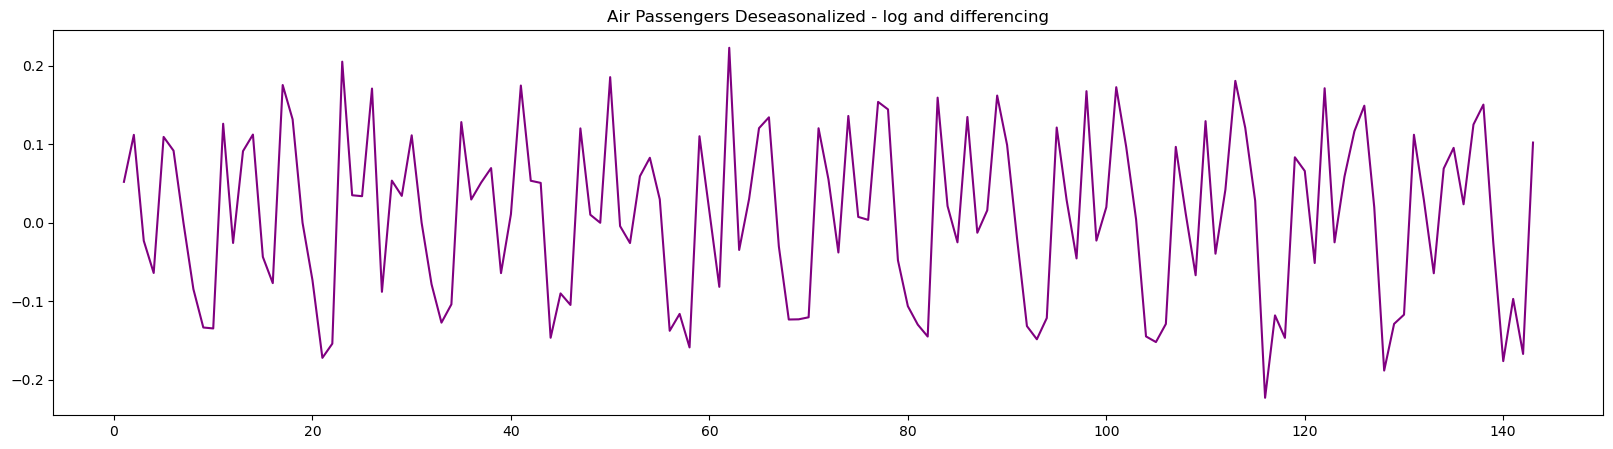

In [18]:
deseas = deseasonalized(df)
plot_deseasonalized(deseas, title="Air Passengers Deseasonalized - log and differencing")

**Check the p-value**

In [36]:
adf_test = adfuller(deseas.dropna())
print(f"p-value: {adf_test[1]}")

p-value: 0.07112054815086723


### Powered transformed

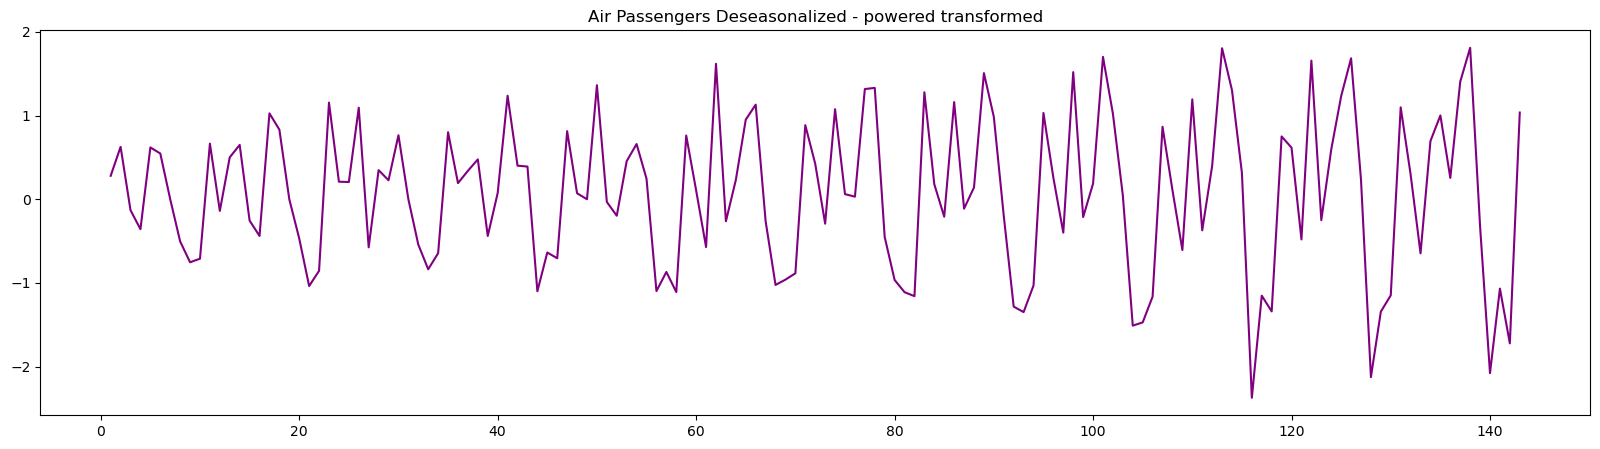

In [52]:
deseas = deseasonalized(df, method="powered_transformed")
plot_deseasonalized(deseas, title="Air Passengers Deseasonalized - powered transformed")

**Check the p-value**

In [46]:
adf_test = adfuller(deseas.dropna())
print(f"p-value: {adf_test[1]}")

p-value: 0.02078418557126867


### Div decompostion

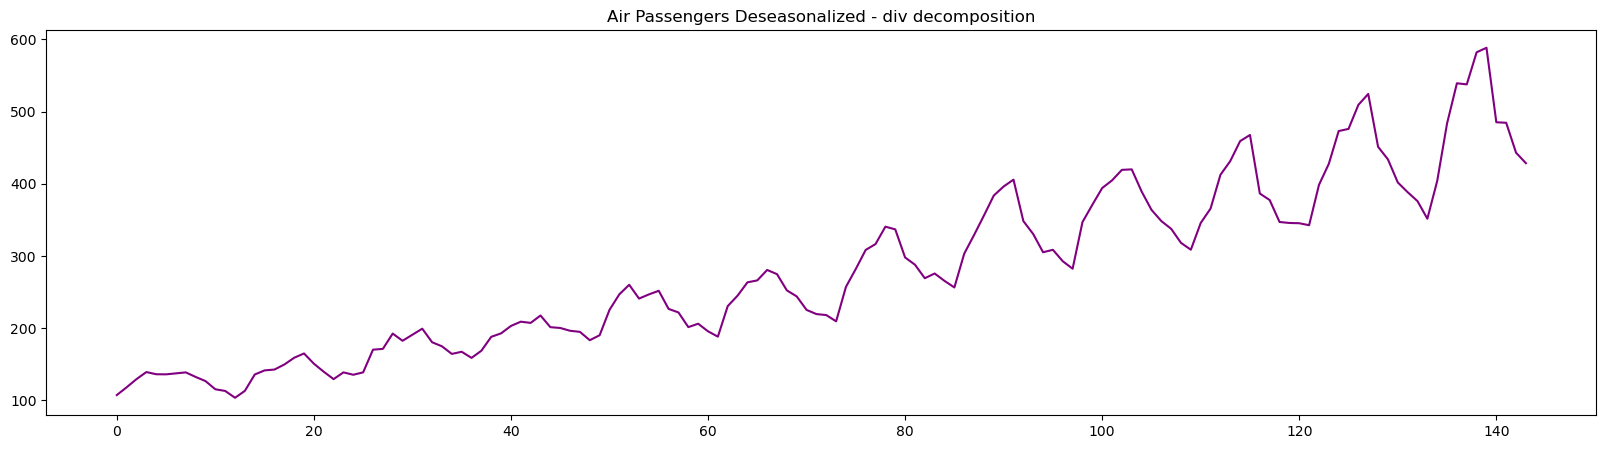

In [47]:
deseas = deseasonalized(df, method="div_decomposition", decomposition=mult_decomposition)
plot_deseasonalized(deseas, title="Air Passengers Deseasonalized - div decomposition")

In [48]:
adf_test = adfuller(deseas.dropna())
print(f"p-value: {adf_test[1]}")

p-value: 0.998121747661861


## Testing seasonality

In [49]:
def testing_seasonality(df: pd.DataFrame, title='Air Passengers: testing seasonality'):
    """This function plot the autocorrelation for testing the seasonality

    Args:
        df (pd.DataFrame): dataframe.
        title (str, optional): Title of the plot. Defaults to 'Air Passengers: testing seasonality'.
    """
    plt.figure(figsize=(20, 8), dpi=100)
    pd.plotting.autocorrelation_plot(df["#Passengers"].to_list(), color="purple")

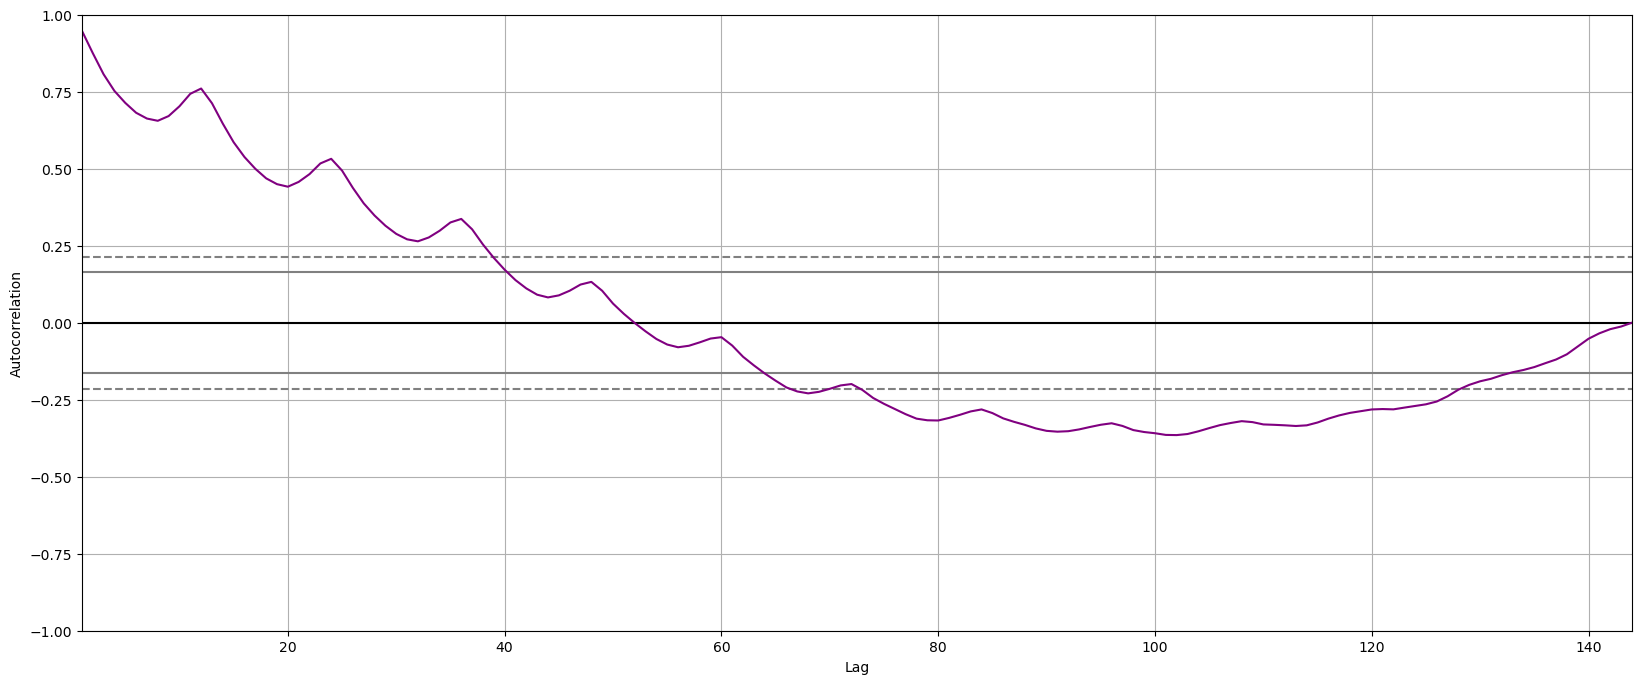

In [50]:
testing_seasonality(df)

## Autocorrelation vs Partial Autocorrelation

In [68]:
def plot_acf_pacf(df: pd.DataFrame):
    """This function plot the autocorrelation and partial autocorrelation

    Args:
        deseas (np.ndarray): Deseasonality of the sereies
    """
    _, ax = plt.subplots(1, 2,figsize=(20, 5), dpi=100)
    plot_acf(df["#Passengers"].values, color="purple", lags=50, ax=ax[0])
    plot_pacf(df["#Passengers"].values, color="purple", lags=50, ax=ax[1], method="ywm")
    plt.show()

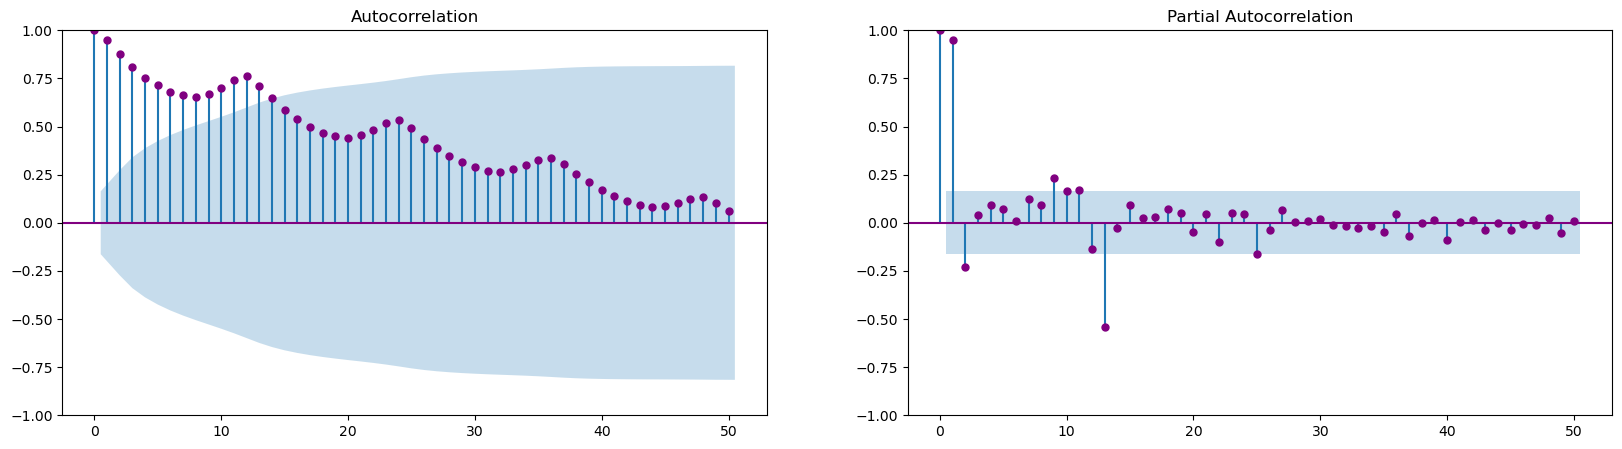

In [69]:
plot_acf_pacf(df)

## Using lag to check if the series is autocorrelated

In [97]:
def plot_lags(df, title=''):
    """This function plot the lags of a series

    Args:
        df (pd.DataFrame): Dataframe
        title (str, optional): Title of the plot. Defaults to ''.
    """
    plt.rcParams.update({"ytick.left": False, "axes.titlepad": 10})
    fig, axes = plt.subplots(1, 10, figsize=(20, 8), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()):
        pd.plotting.lag_plot(df["#Passengers"], lag=i+1, ax=ax, c="firebrick")
        ax.set_title(f"Lag with {str(i+1)}")
    fig.suptitle("Using lag to check autocorrelation")
    plt.show()

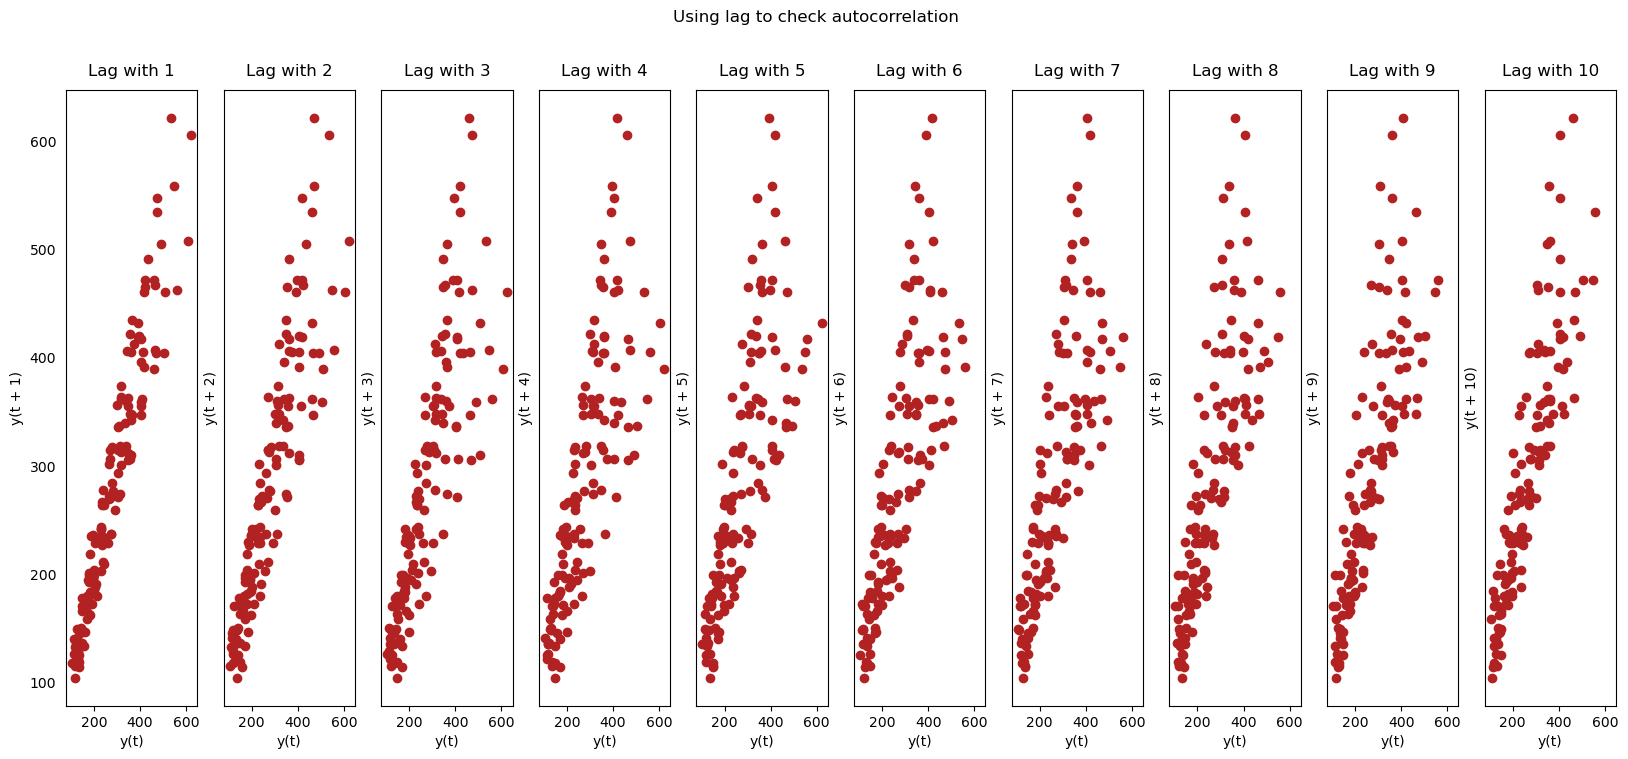

In [98]:
plot_lags(df)